#### Cycling through data science: explore <img src="../images/bicycle32.png" style="float:right">

Preamble: Gather features which might help predict the number of bike users in any given day in Washington, DC, and evaluate the significance of those features and the robustness of the predictions. This is essentially a `regression problem`. Regression problems are inference problems in that we infer, or predict, parameters of a population from a sample. They are also specifically `supervised learning` problems that entail building a model to make predictions about a continuous target variable.

##### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from loguru import logger
import warnings

##### Set parameters

In [2]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

##### Define functions

In [3]:
def plot_correlation_features_to_target(data, target):
    '''Plot heatmap of how features correlate to the target variable.'''
    df_corr = data.corr()[[target]].sort_values(by=target, ascending=False)
    plt.title(label=f'Correlation of features to {target}')
    sns.heatmap(data=df_corr, vmin=-1, vmax=1, cmap='coolwarm', xticklabels=False)

#### 1. Define data science problem

Business problem: predict the number of bike users in any given day in Washington, DC.  
Data science problem: given a set of weather and time variables, predict the number of bike users in a given day.  

#### 2. Gather and process data

In [4]:
# Load daily bike count dataset
path = '../data'
data = pd.read_csv(f'{path}/day.csv')

In [5]:
# Rename and select columns
cols_dict = {
    'cnt': 'count',
    'season': 'season',
    'yr': 'year',
    'mnth': 'month',
    'holiday': 'is_holiday',
    'weekday': 'weekday',
    'workingday': 'is_workingday',
    'weathersit': 'weather',
    'temp': 'temp',
    'atemp': 'temp_feel',
    'hum': 'humdity',
    'windspeed': 'windspeed',
}
data = data.rename(columns=cols_dict).loc[:, cols_dict.values()]

##### Data table

- `count`: count of total rental bikes including both casual and registered 
- `season`: season (1:spring, 2:summer, 3:fall, 4:winter)
- `year`: year (0: 2011, 1:2012)
- `month`: month ( 1 to 12)
- `is_holiday`: whether day is holiday or not
- `weekday`: day of the week
- `is_workingday`: if day is neither weekend nor holiday is 1, otherwise is 0
- `weather`: 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp`: normalized daily temperature in Celsius
- `temp_feel`: normalized daily feeling temperature in Celsius
- `humidity`: normalized humidity. The values are divided to 100 (max)
- `windspeed`: normalized wind speed. The values are divided to 67 (max)

In [6]:
# Assign to df and define target column
df = data
target = 'count'

#### 3. Explore and transform data

##### Header, info, and describe

Insight:  
- Seven categorical features of which four are temporal and three are nominal
- Four numerical features, all of which have already been normalized
- `count` is the target variable
- All features have already been converted to numerical form [see `data table` for more information]
- The number of bikers in any given day range from 22 till 8,714, with an average of 4,500 users per day
- Two years worth of data

In [7]:
# View header
df.head()

,count,season,year,month,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humdity,windspeed
0,985,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,801,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,1349,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,1562,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,1600,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


In [8]:
# View info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   count          731 non-null    int64  
 1   season         731 non-null    int64  
 2   year           731 non-null    int64  
 3   month          731 non-null    int64  
 4   is_holiday     731 non-null    int64  
 5   weekday        731 non-null    int64  
 6   is_workingday  731 non-null    int64  
 7   weather        731 non-null    int64  
 8   temp           731 non-null    float64
 9   temp_feel      731 non-null    float64
 10  humdity        731 non-null    float64
 11  windspeed      731 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 68.7 KB


In [9]:
# Basic statistics on numerical features
df.describe()

,count,season,year,month,is_holiday,weekday,is_workingday,weather,temp,temp_feel,humdity,windspeed
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,4504.348837,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486
std,1937.211452,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498
min,22.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392
25%,3152.000000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950
50%,4548.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975
75%,5956.000000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214
max,8714.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463


In [10]:
# Define categorical features
categorical_features = [
 'season',
 'year',
 'month',
 'is_holiday',
 'weekday',
 'is_workingday'
]

##### Categorical plots

Insight:  
- Spring attracts fewer users on average
- Year 0 [2011] had fewer users than year 1 [2012]
- Months during summer and fall have higher users than those in winter and spring
- Fewer users on holidays
- However, weekends have slightly more users than weekdays

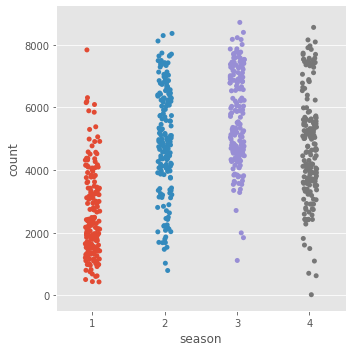

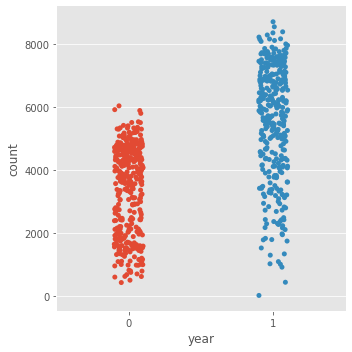

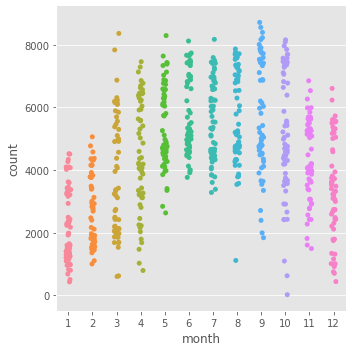

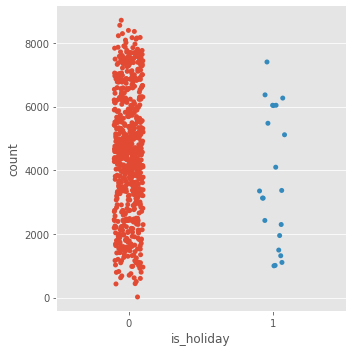

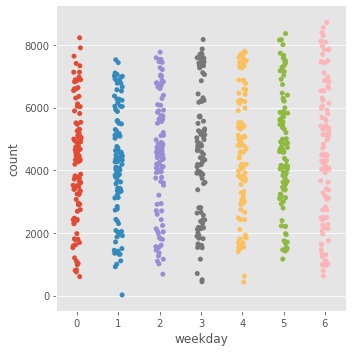

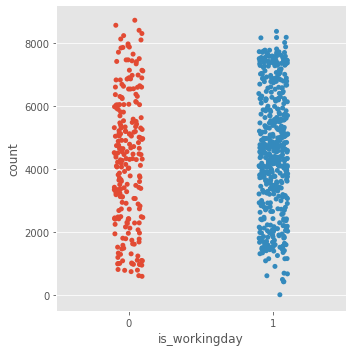

In [11]:
# Plot count plots for each categorical feature
for category in categorical_features:
    sns.catplot(data=df, x=f'{category}', y='count');

##### Violin plots

Insight:  
- Visualize the distribution of each categorical variable and its probablity density

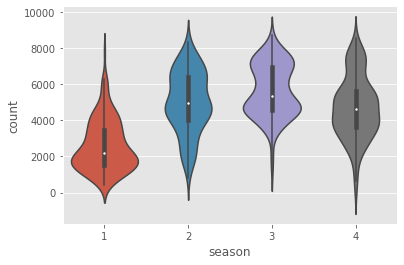

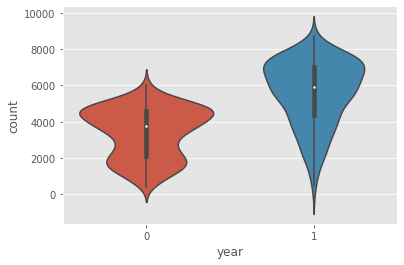

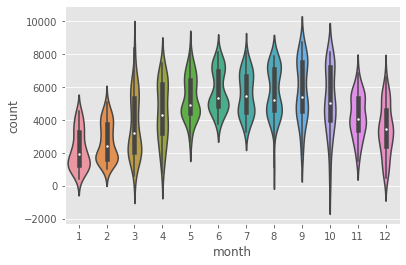

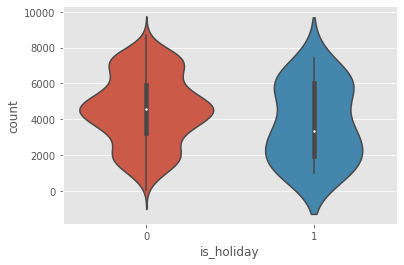

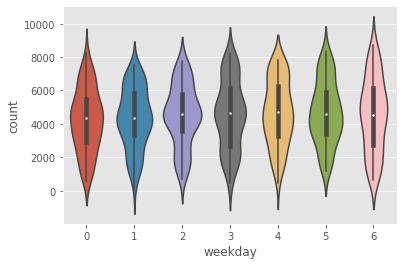

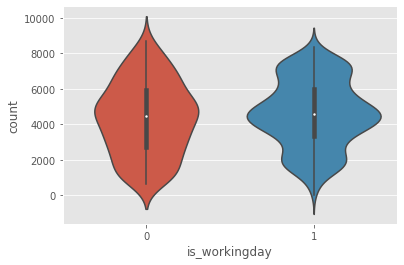

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot violin plots for each categorical feature
for category in categorical_features:
    sns.violinplot(data=df, x=f'{category}', y='count')
    plt.figure();

##### Correlation plot

Insight:  
- `temp` is the most positively correlated feature to the target
- `windspeed` is the most negatively correlated feature to the target
- `weekday` appears to have little correlation to the target

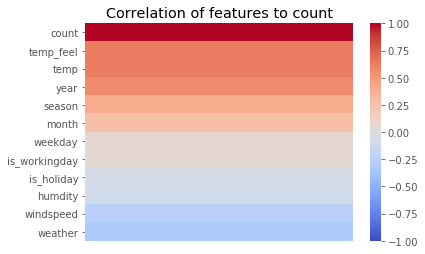

In [13]:
# Plot heatmap of how features correlate to the target variable
plot_correlation_features_to_target(data=df, target=target)

##### Pairplot

Insight:  
- The linear relationship of features to the target variable indicate the slightly positive and negative relationships
- However, more complex relationships between the feature and target are not captured here

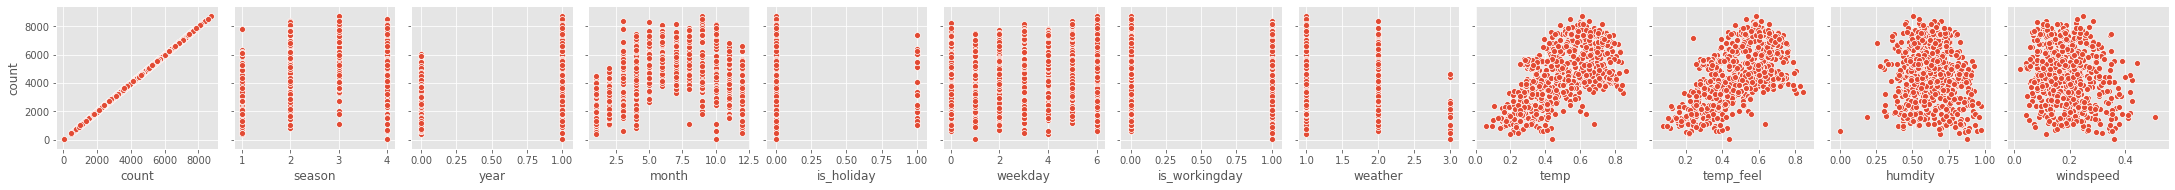

In [14]:
# Observe relationship of target variable to features
sns.pairplot(data=df, y_vars='count', x_vars=df.columns);

##### Distribution plot

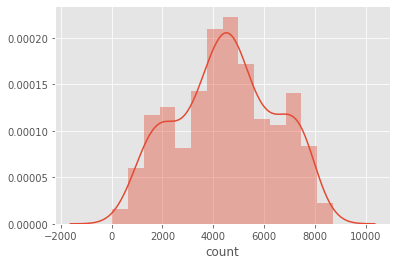

In [15]:
# Distribution of target variable
sns.distplot(a=df[target]);

##### Probability plot

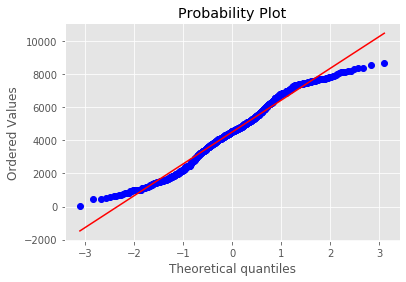

In [16]:
# Normality of target variable
stats.probplot(x=df[target], dist="norm", plot=plt);